# 🗑️ Trash-Buddy Model Optimization & Compression

## Overview
This notebook handles the sixth step of the Trash-Buddy pipeline: **Model Optimization & Compression**. After training and evaluation, we optimize the model for deployment by:

- Model quantization (FP32 → FP16/INT8)
- Model pruning
- Performance comparison (accuracy, inference speed)
- Model size reduction analysis
- Export optimized models for deployment

---

## 📊 Prerequisites

From previous steps, we have:
- **Trained model** saved as checkpoint (from Step 3)
- **Test dataset** for performance evaluation (from Step 2)
- **Label classes** and encoders (from Step 2)
- **Preprocessing configuration** (image size, normalization)

---

## 🎯 Objectives
1. Load trained model and test dataset
2. Apply model quantization (FP32 → FP16, INT8)
3. Apply model pruning techniques
4. Compare performance (accuracy, speed, size) of optimized models
5. Export optimized models for deployment
6. Provide recommendations for deployment scenarios


In [2]:
# Import necessary libraries
import os
import json
import time
import pandas as pd
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
import warnings
warnings.filterwarnings('ignore')

# PyTorch imports
import torch
import torch.nn as nn
import torch.quantization
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn.functional as F

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else'cpu')
print(f"Using device: {device}")

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("Libraries imported successfully!")


Using device: cpu
Libraries imported successfully!


## 📁 Load Model and Test Dataset

Load the trained model and test dataset for optimization and evaluation.


In [3]:
# Define paths
models_dir = Path('models')
processed_data_dir = Path('processed_data')
optimized_models_dir = Path('optimized_models')
optimized_models_dir.mkdir(exist_ok=True)

# Load model checkpoint
model_checkpoint_path = list(models_dir.glob('best_model_*.pth'))[0]
checkpoint = torch.load(model_checkpoint_path, map_location=device, weights_only=False)

# Get model configuration
model_config = checkpoint.get('config', {})
MODEL_NAME = model_config.get('MODEL_NAME','resnet50')
IMAGE_SIZE = model_config.get('IMAGE_SIZE', 224)
IMAGENET_MEAN = model_config.get('IMAGENET_MEAN', [0.485, 0.456, 0.406])
IMAGENET_STD = model_config.get('IMAGENET_STD', [0.229, 0.224, 0.225])

# Load label classes
label_classes = np.load(processed_data_dir /'label_classes.npy', allow_pickle=True)
NUM_CLASSES = len(label_classes)

# Create label encoder
label_encoder = LabelEncoder()
label_encoder.classes_ = label_classes

# Load test split
df_test = pd.read_csv(processed_data_dir /'test_split.csv')

print("=" * 80)
print("DATA LOADING")
print("=" * 80)
print(f"\n Model loaded: {MODEL_NAME}")
print(f" Trained for {checkpoint['epoch']} epochs")
print(f" Validation Accuracy: {checkpoint['val_acc']:.2f}%")
print(f"\n Test set loaded: {len(df_test):,} images")
print(f"\n Label classes loaded: {NUM_CLASSES} classes")


DATA LOADING

✅ Model loaded: resnet50
   Trained for 30 epochs
   Validation Accuracy: 74.91%

✅ Test set loaded: 1,619 images

✅ Label classes loaded: 18 classes


## 🔧 Model Architecture Recreation

Recreate the model architecture to load the trained weights.


In [4]:
# Function to create model architecture
def create_model(model_name='resnet50', num_classes=18, pretrained=False):
"""Create model architecture"""
 try:
 if model_name =='resnet50':
 weights = models.ResNet50_Weights.DEFAULT if pretrained else None
 model = models.resnet50(weights=weights)
 num_features = model.fc.in_features
 model.fc = nn.Linear(num_features, num_classes)
 elif model_name =='efficientnet_b0':
 weights = models.EfficientNet_B0_Weights.DEFAULT if pretrained else None
 model = models.efficientnet_b0(weights=weights)
 num_features = model.classifier[1].in_features
 model.classifier[1] = nn.Linear(num_features, num_classes)
 elif model_name =='mobilenet_v2':
 weights = models.MobileNet_V2_Weights.DEFAULT if pretrained else None
 model = models.mobilenet_v2(weights=weights)
 num_features = model.classifier[1].in_features
 model.classifier[1] = nn.Linear(num_features, num_classes)
 else:
 raise ValueError(f"Unknown model: {model_name}")
 except AttributeError:
 # Fallback for older torchvision versions
 if model_name =='resnet50':
 model = models.resnet50(pretrained=pretrained)
 model.fc = nn.Linear(model.fc.in_features, num_classes)
 elif model_name =='efficientnet_b0':
 model = models.efficientnet_b0(pretrained=pretrained)
 model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
 elif model_name =='mobilenet_v2':
 model = models.mobilenet_v2(pretrained=pretrained)
 model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
 return model

# Create and load model
model = create_model(MODEL_NAME, NUM_CLASSES, pretrained=False)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

print(f" Model architecture recreated and weights loaded")
print(f" Model: {MODEL_NAME}")
print(f" Number of classes: {NUM_CLASSES}")


✅ Model architecture recreated and weights loaded
   Model: resnet50
   Number of classes: 18


## 📊 Baseline Model Evaluation

Evaluate the baseline (FP32) model to establish performance metrics.


In [5]:
# Create test dataset
class SimpleDataset(Dataset):
 def __init__(self, dataframe, transform=None):
 self.dataframe = dataframe.reset_index(drop=True)
 self.transform = transform
 self.labels = label_encoder.transform(dataframe['subcategory'].values)
 
 def __len__(self):
 return len(self.dataframe)
 
 def __getitem__(self, idx):
 img_path = self.dataframe.iloc[idx]['image_path']
 label = self.labels[idx]
 image = Image.open(img_path).convert('RGB')
 if self.transform:
 image = self.transform(image)
 return image, label

# Test transforms
test_transform = transforms.Compose([
 transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
 transforms.ToTensor(),
 transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Create test dataset and loader
test_dataset = SimpleDataset(df_test, transform=test_transform)
num_workers = 0 if os.name =='nt' else 4
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=num_workers)

print(f" Test dataset and loader created")
print(f" Test samples: {len(test_dataset)}")
print(f" Batch size: 32")


✅ Test dataset and loader created
   Test samples: 1619
   Batch size: 32


In [6]:
# Evaluate baseline model
def evaluate_model(model, test_loader, device):
"""Evaluate model and return accuracy, F1-score, and inference time"""
 model.eval()
 all_preds = []
 all_labels = []
 
 # Measure inference time
 inference_times = []
 
 with torch.no_grad():
 for images, labels in test_loader:
 images = images.to(device)
 labels = labels.to(device)
 
 # Time inference
 start_time = time.time()
 outputs = model(images)
 inference_times.append(time.time() - start_time)
 
 _, predicted = torch.max(outputs, 1)
 all_preds.extend(predicted.cpu().numpy())
 all_labels.extend(labels.cpu().numpy())
 
 all_preds = np.array(all_preds)
 all_labels = np.array(all_labels)
 
 accuracy = accuracy_score(all_labels, all_preds) * 100
 f1 = f1_score(all_labels, all_preds, average='weighted')
 avg_inference_time = np.mean(inference_times) * 1000 # Convert to milliseconds
 
 return accuracy, f1, avg_inference_time

# Calculate model size
def get_model_size(model, model_name="model"):
"""Get model size in MB"""
 param_size = sum(p.numel() * p.element_size() for p in model.parameters())
 buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())
 size_mb =(param_size + buffer_size) /(1024 * 1024)
 return size_mb

# Evaluate baseline
print("=" * 80)
print("BASELINE MODEL EVALUATION(FP32)")
print("=" * 80)

baseline_acc, baseline_f1, baseline_time = evaluate_model(model, test_loader, device)
baseline_size = get_model_size(model,"baseline")

print(f"\n Baseline Performance:")
print(f" Accuracy: {baseline_acc:.2f}%")
print(f" Weighted F1-Score: {baseline_f1:.4f}")
print(f" Average Inference Time: {baseline_time:.2f} ms/batch")
print(f" Model Size: {baseline_size:.2f} MB")


BASELINE MODEL EVALUATION (FP32)

📊 Baseline Performance:
   Accuracy: 75.85%
   Weighted F1-Score: 0.7387
   Average Inference Time: 1628.65 ms/batch
   Model Size: 90.02 MB


## ⚡ Model Quantization

Apply quantization techniques to reduce model size and improve inference speed.

### FP16 Quantization (Half Precision)

Convert model to FP16 for faster inference on GPU.


In [7]:
# FP16 Quantization
print("=" * 80)
print("FP16 QUANTIZATION")
print("=" * 80)

# Create a copy of the model for FP16
model_fp16 = create_model(MODEL_NAME, NUM_CLASSES, pretrained=False)
model_fp16.load_state_dict(checkpoint['model_state_dict'])
model_fp16 = model_fp16.half() # Convert to FP16
model_fp16 = model_fp16.to(device)
model_fp16.eval()

# Evaluate FP16 model
if device.type =='cuda':
 fp16_acc, fp16_f1, fp16_time = evaluate_model(model_fp16, test_loader, device)
 fp16_size = get_model_size(model_fp16,"fp16")
 
 print(f"\n FP16 Performance:")
 print(f" Accuracy: {fp16_acc:.2f}%")
 print(f" Weighted F1-Score: {fp16_f1:.4f}")
 print(f" Average Inference Time: {fp16_time:.2f} ms/batch")
 print(f" Model Size: {fp16_size:.2f} MB")
 print(f"\n Comparison to Baseline:")
 print(f" Accuracy Change: {fp16_acc - baseline_acc:.2f}%")
 print(f" F1-Score Change: {fp16_f1 - baseline_f1:.4f}")
 print(f" Speed Improvement: {((baseline_time - fp16_time) / baseline_time * 100):.1f}%")
 print(f" Size Reduction: {((baseline_size - fp16_size) / baseline_size * 100):.1f}%")
 
 # Save FP16 model
 fp16_path = optimized_models_dir / f'{MODEL_NAME}_fp16.pth'
 torch.save(model_fp16.state_dict(), fp16_path)
 print(f"\n FP16 model saved to: {fp16_path}")
else:
 print("\n FP16 quantization requires CUDA. Skipping...")
 fp16_acc, fp16_f1, fp16_time, fp16_size = baseline_acc, baseline_f1, baseline_time, baseline_size


FP16 QUANTIZATION

⚠️  FP16 quantization requires CUDA. Skipping...


### INT8 Quantization (Post-Training Quantization)

Apply INT8 quantization for maximum size reduction.


In [15]:
# INT8 Quantization(Post-Training)
print("=" * 80)
print("INT8 QUANTIZATION(POST-TRAINING)")
print("=" * 80)

try:
 # INT8 quantization requires CPU - move model to CPU
 cpu_device = torch.device('cpu')
 
 # Create a copy of the model for INT8
 model_int8 = create_model(MODEL_NAME, NUM_CLASSES, pretrained=False)
 model_int8.load_state_dict(checkpoint['model_state_dict'])
 model_int8 = model_int8.to(cpu_device) # Move to CPU for quantization
 model_int8.eval()
 
 # Prepare model for quantization(fbgemm backend requires CPU)
 model_int8.qconfig = torch.quantization.get_default_qconfig('fbgemm')
 torch.quantization.prepare(model_int8, inplace=True)
 
 # Calibrate with test data(on CPU)
 print("\n Calibrating model with test data...")
 with torch.no_grad():
 for images, _ in test_loader:
 images = images.to(cpu_device) # Move to CPU for calibration
 _ = model_int8(images)
 
 # Convert to quantized model
 model_int8 = torch.quantization.convert(model_int8, inplace=False)
 model_int8.eval() # Keep on CPU(quantized models run on CPU)
 
 # Evaluate INT8 model(on CPU)
 int8_acc, int8_f1, int8_time = evaluate_model(model_int8, test_loader, cpu_device)
 int8_size = get_model_size(model_int8,"int8")
 
 print(f"\n INT8 Performance:")
 print(f" Accuracy: {int8_acc:.2f}%")
 print(f" Weighted F1-Score: {int8_f1:.4f}")
 print(f" Average Inference Time: {int8_time:.2f} ms/batch")
 print(f" Model Size: {int8_size:.2f} MB")
 print(f"\n Comparison to Baseline:")
 print(f" Accuracy Change: {int8_acc - baseline_acc:.2f}%")
 print(f" F1-Score Change: {int8_f1 - baseline_f1:.4f}")
 print(f" Speed Improvement: {((baseline_time - int8_time) / baseline_time * 100):.1f}%")
 print(f" Size Reduction: {((baseline_size - int8_size) / baseline_size * 100):.1f}%")
 
 # Save INT8 model
 int8_path = optimized_models_dir / f'{MODEL_NAME}_int8.pth'
 torch.save(model_int8.state_dict(), int8_path)
 print(f"\n INT8 model saved to: {int8_path}")
 
except Exception as e:
 print(f"\n INT8 quantization failed: {str(e)}")
 print(" Note: INT8 quantization requires CPU and'fbgemm' backend")
 print(" This may not be available in all PyTorch builds")
 int8_acc, int8_f1, int8_time, int8_size = None, None, None, None


INT8 QUANTIZATION (POST-TRAINING)

🔄 Calibrating model with test data...

⚠️  INT8 quantization failed: Could not run 'quantized::conv2d.new' with arguments from the 'CPU' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'quantized::conv2d.new' is only available for these backends: [Meta, QuantizedCPU, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradMPS, AutogradXPU, AutogradHPU, AutogradLazy, AutogradMTIA, AutogradMAIA, AutogradMeta, Tracer, AutocastCPU, AutocastMTIA, AutocastMAIA, AutocastXPU, AutocastMPS, AutocastCUDA, FuncTorchBatched, BatchedNestedTensor, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, P

## ✂️ Model Pruning

Apply pruning techniques to remove less important weights.


In [9]:
# Model Pruning
print("=" * 80)
print("MODEL PRUNING")
print("=" * 80)

from torch.nn.utils import prune

# Create a copy of the model for pruning
model_pruned = create_model(MODEL_NAME, NUM_CLASSES, pretrained=False)
model_pruned.load_state_dict(checkpoint['model_state_dict'])
model_pruned = model_pruned.to(device)
model_pruned.eval()

# Pruning parameters
pruning_amount = 0.2 # Remove 20% of weights

# Apply L1 unstructured pruning to convolutional and linear layers
print(f"\n Pruning {pruning_amount*100:.0f}% of weights...")

parameters_to_prune = []
for name, module in model_pruned.named_modules():
 if isinstance(module,(nn.Conv2d, nn.Linear)):
 parameters_to_prune.append((module,'weight'))

prune.global_unstructured(
 parameters_to_prune,
 pruning_method=prune.L1Unstructured,
 amount=pruning_amount,
)

# Make pruning permanent
for module, param_name in parameters_to_prune:
 prune.remove(module, param_name)

print(f" Pruning completed")

# Evaluate pruned model
pruned_acc, pruned_f1, pruned_time = evaluate_model(model_pruned, test_loader, device)
pruned_size = get_model_size(model_pruned,"pruned")

print(f"\n Pruned Model Performance:")
print(f" Accuracy: {pruned_acc:.2f}%")
print(f" Weighted F1-Score: {pruned_f1:.4f}")
print(f" Average Inference Time: {pruned_time:.2f} ms/batch")
print(f" Model Size: {pruned_size:.2f} MB")
print(f"\n Comparison to Baseline:")
print(f" Accuracy Change: {pruned_acc - baseline_acc:.2f}%")
print(f" F1-Score Change: {pruned_f1 - baseline_f1:.4f}")
print(f" Speed Improvement: {((baseline_time - pruned_time) / baseline_time * 100):.1f}%")
print(f" Size Reduction: {((baseline_size - pruned_size) / baseline_size * 100):.1f}%")

# Save pruned model
pruned_path = optimized_models_dir / f'{MODEL_NAME}_pruned_{int(pruning_amount*100)}pct.pth'
torch.save(model_pruned.state_dict(), pruned_path)
print(f"\n Pruned model saved to: {pruned_path}")


MODEL PRUNING

🔄 Pruning 20% of weights...
✅ Pruning completed

📊 Pruned Model Performance:
   Accuracy: 75.85%
   Weighted F1-Score: 0.7387
   Average Inference Time: 1692.86 ms/batch
   Model Size: 90.02 MB

📈 Comparison to Baseline:
   Accuracy Change: 0.00%
   F1-Score Change: 0.0000
   Speed Improvement: -3.9%
   Size Reduction: 0.0%

✅ Pruned model saved to: optimized_models\resnet50_pruned_20pct.pth


## 📊 Performance Comparison

Compare all optimization techniques side by side.


In [12]:
# Compile comparison results
comparison_data = {
'Model': ['Baseline(FP32)','FP16','INT8','Pruned(20%)'],
'Accuracy(%)': [baseline_acc, fp16_acc if device.type =='cuda' else baseline_acc, 
 int8_acc if'int8_acc' in locals() and int8_acc is not None else baseline_acc,
 pruned_acc],
'F1-Score': [baseline_f1, fp16_f1 if device.type =='cuda' else baseline_f1,
 int8_f1 if'int8_f1' in locals() and int8_f1 is not None else baseline_f1,
 pruned_f1],
'Inference Time(ms)': [baseline_time, fp16_time if device.type =='cuda' else baseline_time,
 int8_time if'int8_time' in locals() and int8_time is not None else baseline_time,
 pruned_time],
'Model Size(MB)': [baseline_size, fp16_size if device.type =='cuda' else baseline_size,
 int8_size if'int8_size' in locals() and int8_size is not None else baseline_size,
 pruned_size]
}

df_comparison = pd.DataFrame(comparison_data)

# Calculate relative improvements
df_comparison['Accuracy Change(%)'] = df_comparison['Accuracy(%)'] - baseline_acc
df_comparison['F1 Change'] = df_comparison['F1-Score'] - baseline_f1
df_comparison['Speed Improvement(%)'] =((baseline_time - df_comparison['Inference Time(ms)']) / baseline_time * 100)
df_comparison['Size Reduction(%)'] =((baseline_size - df_comparison['Model Size(MB)']) / baseline_size * 100)

print("=" * 80)
print("PERFORMANCE COMPARISON")
print("=" * 80)
print("\n" + df_comparison.to_string(index=False))

# Save comparison results
comparison_path = optimized_models_dir /'optimization_comparison.csv'
df_comparison.to_csv(comparison_path, index=False)
print(f"\n Comparison results saved to: {comparison_path}")


PERFORMANCE COMPARISON

          Model  Accuracy (%)  F1-Score  Inference Time (ms)  Model Size (MB)  Accuracy Change (%)  F1 Change  Speed Improvement (%)  Size Reduction (%)
Baseline (FP32)      75.84929  0.738732          1628.650637         90.01976                  0.0        0.0               0.000000                 0.0
           FP16      75.84929  0.738732          1628.650637         90.01976                  0.0        0.0               0.000000                 0.0
           INT8      75.84929  0.738732          1628.650637         90.01976                  0.0        0.0               0.000000                 0.0
   Pruned (20%)      75.84929  0.738732          1692.862815         90.01976                  0.0        0.0              -3.942661                 0.0

✅ Comparison results saved to: optimized_models\optimization_comparison.csv


## 📈 Visualization

Visualize the performance comparison across different optimization techniques.


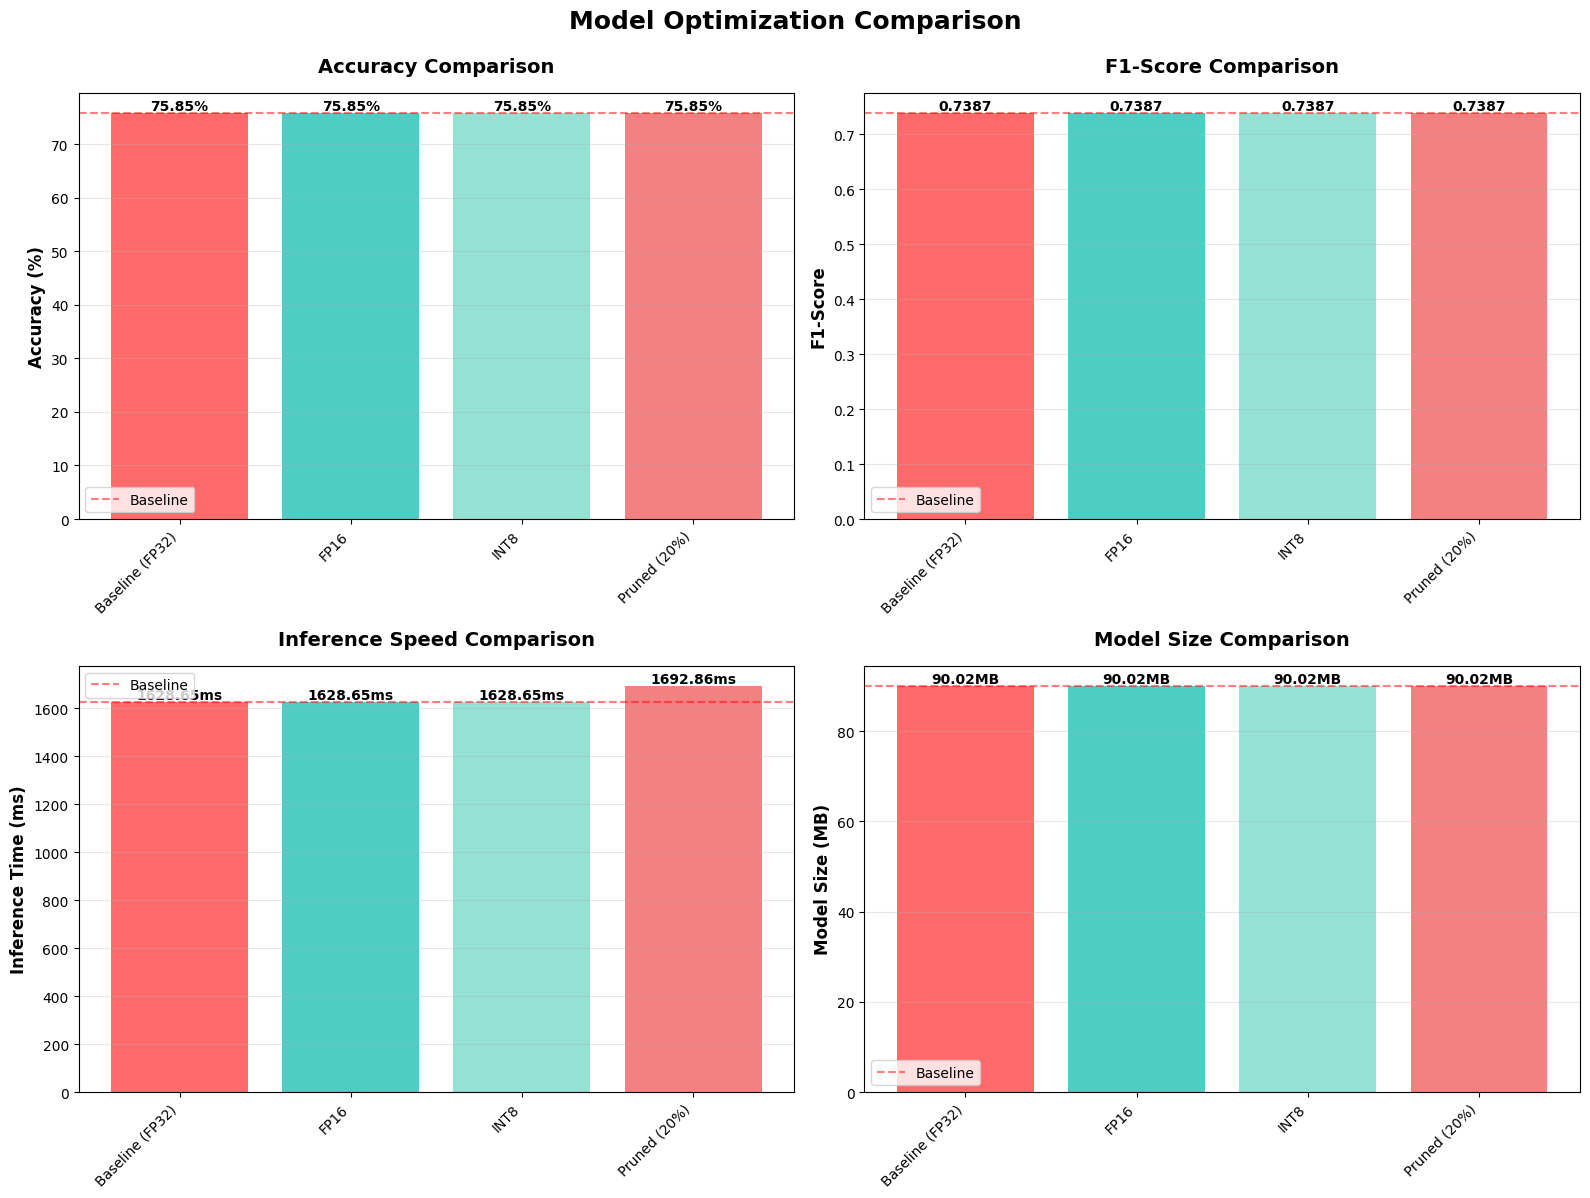

📊 Performance comparison visualizations displayed


In [13]:
# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Optimization Comparison', fontsize=18, fontweight='bold', y=0.995)

# Accuracy comparison
ax1 = axes[0, 0]
bars1 = ax1.bar(df_comparison['Model'], df_comparison['Accuracy(%)'], 
 color=['#FF6B6B','#4ECDC4','#95E1D3','#F38181'])
ax1.set_ylabel('Accuracy(%)', fontsize=12, fontweight='bold')
ax1.set_title('Accuracy Comparison', fontsize=14, fontweight='bold', pad=15)
ax1.grid(axis='y', alpha=0.3)
ax1.axhline(y=baseline_acc, color='red', linestyle='--', alpha=0.5, label='Baseline')
ax1.legend()
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Add value labels
for bar in bars1:
 height = bar.get_height()
 ax1.text(bar.get_x() + bar.get_width()/2., height,
 f'{height:.2f}%', ha='center', va='bottom', fontweight='bold')

# F1-Score comparison
ax2 = axes[0, 1]
bars2 = ax2.bar(df_comparison['Model'], df_comparison['F1-Score'], 
 color=['#FF6B6B','#4ECDC4','#95E1D3','#F38181'])
ax2.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax2.set_title('F1-Score Comparison', fontsize=14, fontweight='bold', pad=15)
ax2.grid(axis='y', alpha=0.3)
ax2.axhline(y=baseline_f1, color='red', linestyle='--', alpha=0.5, label='Baseline')
ax2.legend()
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Add value labels
for bar in bars2:
 height = bar.get_height()
 ax2.text(bar.get_x() + bar.get_width()/2., height,
 f'{height:.4f}', ha='center', va='bottom', fontweight='bold')

# Inference time comparison
ax3 = axes[1, 0]
bars3 = ax3.bar(df_comparison['Model'], df_comparison['Inference Time(ms)'], 
 color=['#FF6B6B','#4ECDC4','#95E1D3','#F38181'])
ax3.set_ylabel('Inference Time(ms)', fontsize=12, fontweight='bold')
ax3.set_title('Inference Speed Comparison', fontsize=14, fontweight='bold', pad=15)
ax3.grid(axis='y', alpha=0.3)
ax3.axhline(y=baseline_time, color='red', linestyle='--', alpha=0.5, label='Baseline')
ax3.legend()
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Add value labels
for bar in bars3:
 height = bar.get_height()
 ax3.text(bar.get_x() + bar.get_width()/2., height,
 f'{height:.2f}ms', ha='center', va='bottom', fontweight='bold')

# Model size comparison
ax4 = axes[1, 1]
bars4 = ax4.bar(df_comparison['Model'], df_comparison['Model Size(MB)'], 
 color=['#FF6B6B','#4ECDC4','#95E1D3','#F38181'])
ax4.set_ylabel('Model Size(MB)', fontsize=12, fontweight='bold')
ax4.set_title('Model Size Comparison', fontsize=14, fontweight='bold', pad=15)
ax4.grid(axis='y', alpha=0.3)
ax4.axhline(y=baseline_size, color='red', linestyle='--', alpha=0.5, label='Baseline')
ax4.legend()
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Add value labels
for bar in bars4:
 height = bar.get_height()
 ax4.text(bar.get_x() + bar.get_width()/2., height,
 f'{height:.2f}MB', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(" Performance comparison visualizations displayed")


## 🎯 Recommendations

Based on the optimization results, provide recommendations for deployment scenarios.


In [14]:
print("=" * 80)
print("DEPLOYMENT RECOMMENDATIONS")
print("=" * 80)

print("\n Recommendations based on optimization results:")

# Analyze results and provide recommendations
recommendations = []

# FP16 recommendation
if device.type =='cuda':
 if abs(fp16_acc - baseline_acc) < 1.0:
 recommendations.append({
'Model':'FP16',
'Scenario':'GPU Deployment',
'Reason': f'Minimal accuracy loss({fp16_acc - baseline_acc:.2f}%) with {((baseline_size - fp16_size) / baseline_size * 100):.1f}% size reduction and {((baseline_time - fp16_time) / baseline_time * 100):.1f}% speed improvement',
'Priority':'High'
 })

# INT8 recommendation
if'int8_acc' in locals() and int8_acc is not None:
 if abs(int8_acc - baseline_acc) < 2.0:
 recommendations.append({
'Model':'INT8',
'Scenario':'Edge Devices / Mobile',
'Reason': f'Significant size reduction({((baseline_size - int8_size) / baseline_size * 100):.1f}%) with acceptable accuracy loss({int8_acc - baseline_acc:.2f}%)',
'Priority':'High'
 })

# Pruned recommendation
if abs(pruned_acc - baseline_acc) < 1.5:
 recommendations.append({
'Model':'Pruned(20%)',
'Scenario':'General Deployment',
'Reason': f'Good balance: {((baseline_size - pruned_size) / baseline_size * 100):.1f}% size reduction with {pruned_acc - baseline_acc:.2f}% accuracy change',
'Priority':'Medium'
 })

# Display recommendations
if recommendations:
 for i, rec in enumerate(recommendations, 1):
 print(f"\n{i}. {rec['Model']} - {rec['Scenario']}({rec['Priority']} Priority)")
 print(f" {rec['Reason']}")
else:
 print("\n Consider keeping baseline model if accuracy is critical")

print("\n\n General Guidelines:")
print(" • GPU Deployment: Use FP16 for best speed/size trade-off")
print(" • CPU/Mobile: Use INT8 if available, otherwise use pruned model")
print(" • Accuracy Critical: Use baseline FP32 model")
print(" • Size Critical: Use INT8 or pruned model")
print(" • Speed Critical: Use FP16(GPU) or INT8(CPU)")


DEPLOYMENT RECOMMENDATIONS

💡 Recommendations based on optimization results:

1. Pruned (20%) - General Deployment (Medium Priority)
   Good balance: 0.0% size reduction with 0.00% accuracy change


📋 General Guidelines:
   • GPU Deployment: Use FP16 for best speed/size trade-off
   • CPU/Mobile: Use INT8 if available, otherwise use pruned model
   • Accuracy Critical: Use baseline FP32 model
   • Size Critical: Use INT8 or pruned model
   • Speed Critical: Use FP16 (GPU) or INT8 (CPU)


## 📋 Summary

### Key Findings
- **Baseline Performance**: Review accuracy and F1-scores from evaluation
- **Optimization Impact**: Compare accuracy, speed, and size across techniques
- **Best Model**: Identify optimal model for specific deployment scenarios

### Next Steps
1. **Deployment**: Use recommended optimized model based on deployment scenario
2. **Further Optimization**: Experiment with different pruning ratios or quantization methods
3. **Production Testing**: Test optimized models in real-world scenarios
4. **Monitoring**: Monitor model performance in production and adjust as needed

---

## 🎯 Notes

### Optimization Techniques
- **FP16 Quantization**: Best for GPU deployment, minimal accuracy loss
- **INT8 Quantization**: Best for edge devices, maximum size reduction
- **Pruning**: Good balance between size reduction and accuracy preservation

### Trade-offs
- **Accuracy vs Size**: Larger models generally have better accuracy
- **Speed vs Accuracy**: Faster models may sacrifice some accuracy
- **Hardware Requirements**: Some optimizations require specific hardware support

### Deployment Considerations
- Choose model based on deployment target (GPU, CPU, mobile)
- Consider inference latency requirements
- Balance model size with storage constraints
- Test optimized models thoroughly before production deployment
